## A Complex Example: HTMLParser

我们在一个更实际的例子上比较这三种模糊测试器的性能，我们选择Python的HTML解析器作为测试目标。我们将从"空"种子开始，对HTMLParser分别运行这三种模糊测试器各5000次。

解释关键点：

- "more realistic example" - 更实际的例子，指Python的HTML解析器

- "three fuzzers" - 三种模糊测试器，指：
    - 基础的黑盒模糊测试器
    - 普通的灰盒模糊测试器
    - 改进的（boosted）灰盒模糊测试器
- "n = 5k" - 5000次测试运行
- "empty seed" - 从空字符串作为初始种子开始测试
这个例子比之前的crashme函数更复杂，更能体现不同模糊测试策略的优劣。

In [6]:
from html.parser import HTMLParser

In [7]:
# create wrapper function
def my_parser(inp: str) -> None:
    parser = HTMLParser()  # resets the HTMLParser object for every fuzz input
    parser.feed(inp)

In [8]:
from fuzzingbook.GreyboxFuzzer import AdvancedMutationFuzzer, GreyboxFuzzer, CountingGreyboxFuzzer
from fuzzingbook.GreyboxFuzzer import Seed, Mutator, PowerSchedule
from fuzzingbook.GreyboxFuzzer import AFLFastSchedule
import time
from fuzzingbook.MutationFuzzer import FunctionCoverageRunner
from fuzzingbook.Coverage import population_coverage
from matplotlib import pyplot as plt

In [9]:
n = 8000
seed_input = " "  # empty seed
blackbox_fuzzer = AdvancedMutationFuzzer([seed_input], Mutator(), PowerSchedule())
greybox_fuzzer = GreyboxFuzzer([seed_input], Mutator(), PowerSchedule())
boosted_fuzzer = CountingGreyboxFuzzer([seed_input], Mutator(), AFLFastSchedule(5))

In [10]:
start = time.time()
blackbox_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
greybox_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
boosted_fuzzer.runs(FunctionCoverageRunner(my_parser), trials=n)
end = time.time()

"It took all three fuzzers %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took all three fuzzers 55.24 seconds to generate and execute 8000 inputs.'

这些模糊测试器在随时间推移的代码覆盖率方面如何比较？

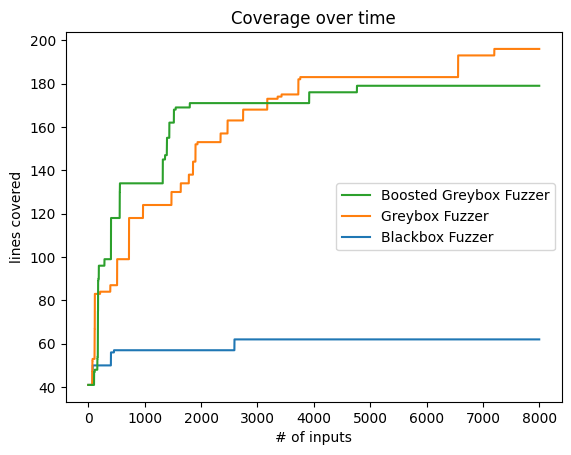

In [11]:
_, black_coverage = population_coverage(blackbox_fuzzer.inputs, my_parser)
_, grey_coverage = population_coverage(greybox_fuzzer.inputs, my_parser)
_, boost_coverage = population_coverage(boosted_fuzzer.inputs, my_parser)
line_black, = plt.plot(black_coverage, label="Blackbox Fuzzer")
line_grey, = plt.plot(grey_coverage, label="Greybox Fuzzer")
line_boost, = plt.plot(boost_coverage, label="Boosted Greybox Fuzzer")
plt.legend(handles=[line_boost, line_grey, line_black])
plt.title('Coverage over time')
plt.xlabel('# of inputs')
plt.ylabel('lines covered');

In [14]:
print('----------blackbox----------')
blackbox_fuzzer.inputs[-10:]


----------blackbox----------


['', '"', " '", '', '', 'a ', '!', '', 'W ', 'C ']

In [15]:
print('----------greybox----------')
greybox_fuzzer.inputs[-10:]

----------greybox----------


['h5<&0\n!V#',
 'x"\x11\x1b&%<tD\'H\x14i19*OZgPf@R`7Ul>',
 '\n_N8',
 'M<.^<`.',
 '',
 'f<\x10l;9eljjjfpoxjg7Qz',
 '~VfG< "(\x1dK?nlj:j?V(~-(',
 'fml4"xC9+fKn&#0\x19Bx<\'<V*a}8mF`Vq8',
 'f\nc/1&^\x1egY6P $;jv<',
 '&D</D>lj1ljj\x17cot`q.z']

# Directed Greybox Fuzzing

定向灰盒模糊测试

有时候，你可能希望模糊测试工具能够到达源代码中的某个危险位置。这可能是你预期会发生缓冲区溢出的位置，或者你希望测试代码库中最近的更改。我们如何引导模糊测试工具前往这些位置？

在本章中，我们将介绍将定向灰盒模糊测试视为一种优化问题。

## Solving the Maze


为了提供一个有意义的例子，使你可以轻松更改代码复杂性和目标位置，我们根据迷宫字符串生成迷宫源代码。

In [16]:
maze_string = """
+-+-----+
|X|     |
| | --+ |
| |   | |
| +-- | |
|     |#|
+-----+-+
"""

这段代码是由函数 generate_maze_code() 生成的。将隐藏具体实现，而是解释它的功能。如果你对实现细节感兴趣，请点击[这里](https://www.fuzzingbook.org/html/ControlFlow.html#Example:-Maze)。

In [21]:
from fuzzingbook.ControlFlow import generate_maze_code
maze_code = generate_maze_code(maze_string)
exec(maze_code)

目标是通过输入 D（向下）、U（向上）、L（向左）和 R（向右）来使"X"到达"#"。

In [22]:
print(maze("DDDDRRRRUULLUURRRRDDDD"))  # Appending one more 'D', you have reached the target.

SOLVED

+-+-----+
| |     |
| | --+ |
| |   | |
| +-- | |
|     |X|
+-----+-+



maze_string 中的每个字符代表一个格子。对于每个格子，都会生成一个对应的格子函数。

如果当前格子是"安全的"（空格），则会调用与下一个输入字符（D、U、L、R）对应的格子函数。未预期的输入字符会被忽略。如果没有更多的输入字符，它会返回"VALID"和当前迷宫状态。 如果当前格子是"陷阱"（+、|、-），它会返回"INVALID"和当前迷宫状态。 如果当前格子是"目标"（#），它会返回"SOLVED"和当前迷宫状态。

你可以试试看。你可以测试其他的输入字符序列，甚至可以完全改变迷宫。要执行你自己的代码，你只需要以 Jupyter notebook 的形式打开本章节。

为了了解生成的代码，让我们看看静态调用图。调用图展示了函数可以被执行的顺序。

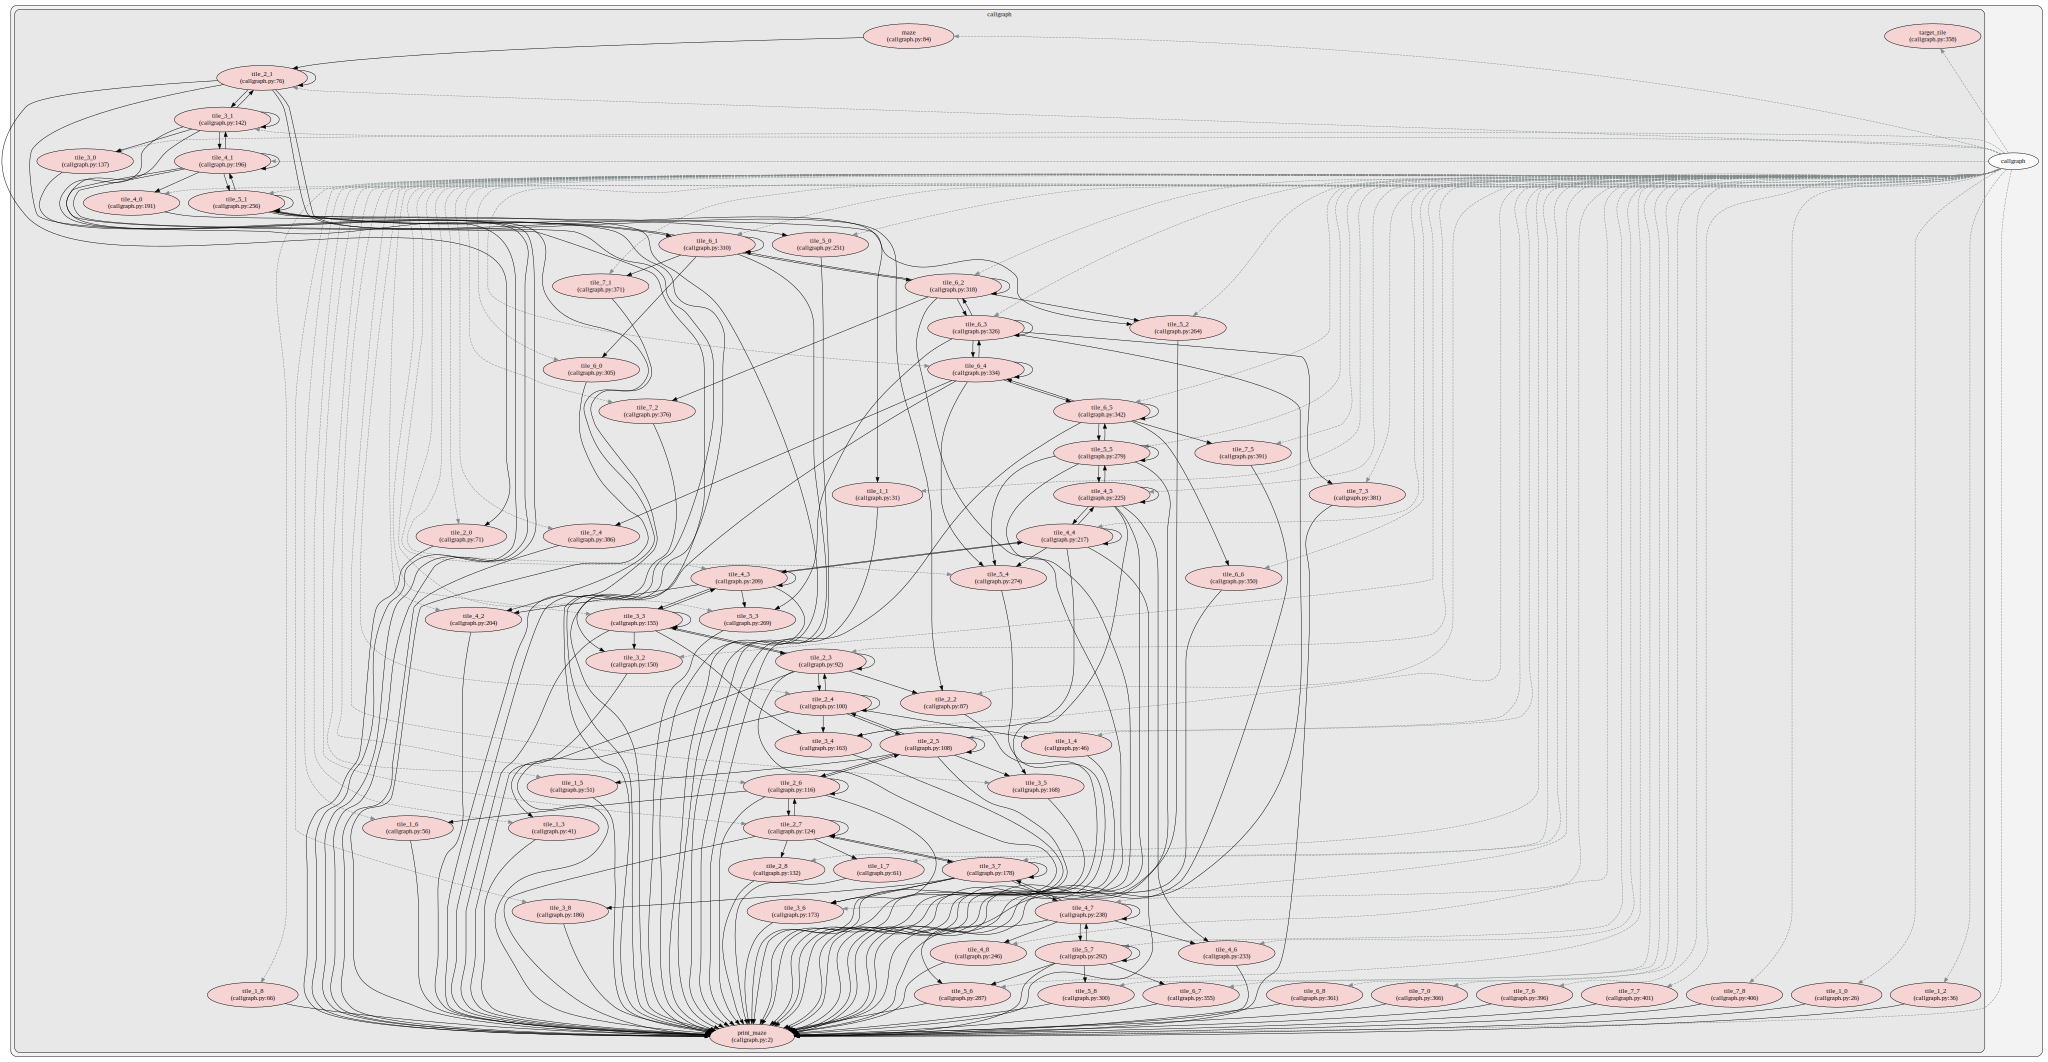

In [33]:
from fuzzingbook.ControlFlow import callgraph
callgraph(maze_code)


## A First Attempt

我们引入一个 DictMutator 类，它通过从给定的字典中插入关键字来改变字符串：

In [35]:
from typing import List, Set, Any, Tuple, Dict, Union, Sequence
class DictMutator(Mutator):
    """Variant of `Mutator` inserting keywords from a dictionary"""

    def __init__(self, dictionary: Sequence[str]) -> None:
        """Constructor.
        `dictionary` - a list of strings that can be used as keywords
        """
        super().__init__()
        self.dictionary = dictionary
        self.mutators.append(self.insert_from_dictionary)

    def insert_from_dictionary(self, s: str) -> str:
        """Returns `s` with a keyword from the dictionary inserted"""
        pos = random.randint(0, len(s))
        random_keyword = random.choice(self.dictionary)
        return s[:pos] + random_keyword + s[pos:]

为了fuzz迷宫，我们扩展了 DictMutator 类，将字典关键字附加到种子的末尾，并从种子的末尾删除一个字符

In [36]:
class MazeMutator(DictMutator):
    def __init__(self, dictionary: Sequence[str]) -> None:
        super().__init__(dictionary)
        self.mutators.append(self.delete_last_character)
        self.mutators.append(self.append_from_dictionary)

    def append_from_dictionary(self, s: str) -> str:
        """Returns s with a keyword from the dictionary appended"""
        random_keyword = random.choice(self.dictionary)
        return s + random_keyword

    def delete_last_character(self, s: str) -> str:
        """Returns s without the last character"""
        if len(s) > 0:
            return s[:-1]
        return s

让我们尝试使用classic power schedule和我们的扩展迷宫变异器（n = 20k）的标准灰盒模糊测试器

In [38]:
import time
import random
n = 20000
seed_input = " "  # empty seed

maze_mutator = MazeMutator(["L", "R", "U", "D"])
maze_schedule = PowerSchedule()
maze_fuzzer = GreyboxFuzzer([seed_input], maze_mutator, maze_schedule)

start = time.time()
maze_fuzzer.runs(FunctionCoverageRunner(maze), trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 13.33 seconds to generate and execute 20000 inputs.'

我们需要打印多个模糊测试器的统计数据。我们为此定义一个函数

In [39]:
def print_stats(fuzzer: GreyboxFuzzer) -> None:
    total = len(fuzzer.population)
    solved = 0
    invalid = 0
    valid = 0
    for seed in fuzzer.population:
        s = maze(str(seed.data))
        if "INVALID" in s:
            invalid += 1
        elif "VALID" in s:
            valid += 1
        elif "SOLVED" in s:
            solved += 1
            if solved == 1:
                print("First solution: %s" % repr(seed))
        else:
            print("??")

    print("""Out of %d seeds,
* %4d solved the maze,
* %4d were valid but did not solve the maze, and
* %4d were invalid""" % (total, solved, valid, invalid))

我们的老款灰盒模糊测试器表现如何？

In [40]:
print_stats(maze_fuzzer)

Out of 1500 seeds,
*    0 solved the maze,
*  352 were valid but did not solve the maze, and
* 1148 were invalid


它可能一次都没能解决迷宫。我们如何让模糊器知道种子距离目标还有多“远”？如果我们知道，我们可以为该种子分配更多能量。

试试看。使用 AFLFastSchedule 和 CountingGreyboxFuzzer 打印增强模糊器的统计数据。它的性能可能会比未增强的灰盒模糊器好得多：概率最低的路径恰好也是到达目标的路径。

## Computing Function-Level Distance

使用迷宫代码的静态调用图和目标函数，我们可以计算每个函数 f 到目标 t 的距离，这个距离就是 f 和 t 之间的最短路径长度。

幸运的是，生成的迷宫代码包含一个名为 target_tile 的函数，它可以返回目标函数的名称。

在这个迷宫代码中，目标 t 指的是迷宫中的目标位置，也就是 "#" 符号所在的位置对应的函数。每个迷宫格子都对应着一个函数，而 "#" 所在位置的函数就是我们的目标函数（target function）。当玩家的 "X" 到达这个位置时，就表示成功解决了迷宫。

target_tile 函数会返回这个目标位置（"#"）对应的函数名称。这个函数名称会被用来计算其他函数到达目标的距离，这个距离就是在函数调用图中从任意函数到目标函数的最短路径长度。





In [41]:
target = target_tile()
target

'tile_6_7'

现在，我们需要在调用图中找到相应的函数。函数 get_callgraph 将迷宫代码的调用图作为 networkx 图返回。Networkx 提供了一些用于图形分析的有用函数。

In [42]:
import networkx as nx
from fuzzingbook.ControlFlow import get_callgraph

cg = get_callgraph(maze_code)
for node in cg.nodes():
    if target in node:
        target_node = node
        break

In [43]:
target_node

'callgraphX__tile_6_7'

现在我们可以生成函数级距离。字典距离包含每个函数到目标函数的距离。如果没有到目标的路径，我们将指定最大距离 (0xFFFF)。

函数 nx.shortest_path_length(CG, node, target_node) 返回调用图 CG 中从函数节点到函数 target_node 的最短路径的长度。

In [44]:
distance = {}
for node in cg.nodes():
    if "__" in node:
        name = node.split("__")[-1]
    else:
        name = node
    try:
        distance[name] = nx.shortest_path_length(cg, node, target_node)
    except:
        distance[name] = 0xFFFF

这些是到目标函数的路径上所有图块函数的距离值。

In [45]:
{k: distance[k] for k in list(distance) if distance[k] < 0xFFFF}

{'callgraphX': 1,
 'maze': 23,
 'tile_2_1': 22,
 'tile_2_3': 8,
 'tile_2_4': 7,
 'tile_2_5': 6,
 'tile_2_6': 5,
 'tile_2_7': 4,
 'tile_3_1': 21,
 'tile_3_3': 9,
 'tile_3_7': 3,
 'tile_4_1': 20,
 'tile_4_3': 10,
 'tile_4_4': 11,
 'tile_4_5': 12,
 'tile_4_7': 2,
 'tile_5_1': 19,
 'tile_5_5': 13,
 'tile_5_7': 1,
 'tile_6_1': 18,
 'tile_6_2': 17,
 'tile_6_3': 16,
 'tile_6_4': 15,
 'tile_6_5': 14,
 'tile_6_7': 0}

利用静态调用图和目标函数t，我们已经展示了如何计算每个函数f到目标t的函数级距离。

实践：你可以通过将本章作为Jupyter笔记本打开来尝试执行自己的代码。

- 如果有多个目标，我们如何计算距离？（提示：几何平均）

- 给定调用图(CG)和每个函数f的控制流图(CFGf)，我们如何计算基本块(BB)级别的距离？（提示：在CFGf中，测量基本块到通向目标函数路径上的函数调用的距离。记住，在函数级距离更高的函数中，基本块级距离也更高。）

阅读建议：如果你对搜索的其他方面感兴趣，可以继续阅读"基于搜索的模糊测试"[这一章](https://www.fuzzingbook.org/html/SearchBasedFuzzer.html)。如果你对如何解决上述问题感兴趣，可以看看我们关于"定向灰盒模糊测试"的[论文](Directed Greybox Fuzzing)。

## Directed Power Schedule

现在我们知道了如何计算函数级距离，让我们尝试实现一个功率调度，为平均距离到目标函数更低的种子分配更多能量。请注意，距离值都是预先计算的。这些值被注入到程序二进制中，就像覆盖率检测一样。在实践中，这使得计算平均距离非常高效。

如果你真想知道。给定函数 $s$ 到函数 $t$ 在调用图 $CG$ 中的函数级距离 $d_f(s,t)$，我们的定向功率调度会计算种子 $i$ 到函数 $t$ 的种子距离 $d(i,t)$ ，计算公式如下：

$$d(i,t) = \frac{\sum_{s\in CG} d_f(s,t)}{|CG|}$$

其中 $|CG|$ 是调用图 $CG$ 中的节点数量。



In [47]:
from fuzzingbook.Coverage import Location
class DirectedSchedule(PowerSchedule):
    """Assign high energy to seeds close to some target"""

    def __init__(self, distance: Dict[str, int], exponent: float) -> None:
        self.distance = distance
        self.exponent = exponent

    def __getFunctions__(self, coverage: Set[Location]) -> Set[str]:
        functions = set()
        for f, _ in set(coverage):
            functions.add(f)
        return functions

    def assignEnergy(self, population: Sequence[Seed]) -> None:
        """Assigns each seed energy inversely proportional
           to the average function-level distance to target."""
        for seed in population:
            if seed.distance < 0:
                num_dist = 0
                sum_dist = 0
                for f in self.__getFunctions__(seed.coverage):
                    if f in list(self.distance):
                        sum_dist += self.distance[f]
                        num_dist += 1
                seed.distance = sum_dist / num_dist
                seed.energy = (1 / seed.distance) ** self.exponent

让我们看看有向调度与那个好用的老灰盒模糊器相比表现如何。

In [48]:
directed_schedule = DirectedSchedule(distance, 3)
directed_fuzzer = GreyboxFuzzer([seed_input], maze_mutator, directed_schedule)

start = time.time()
directed_fuzzer.runs(FunctionCoverageRunner(maze), trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 17.13 seconds to generate and execute 20000 inputs.'

In [49]:
print_stats(directed_fuzzer)

Out of 2362 seeds,
*    0 solved the maze,
*  915 were valid but did not solve the maze, and
* 1447 were invalid


可能一个迷宫都没有解决，但我们有更多有效的解决方案。所以，肯定有进步。

让我们看看每个种子的距离值。

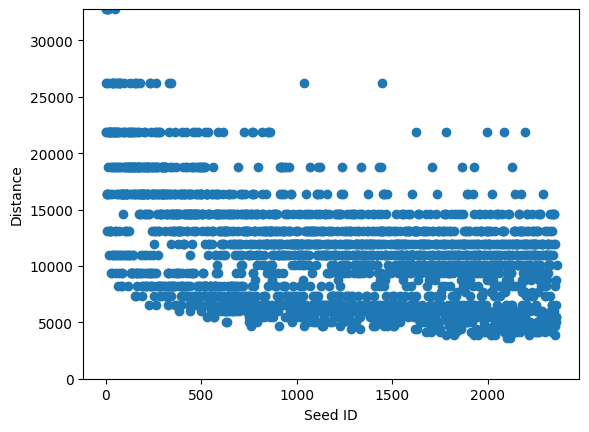

In [50]:
y = [seed.distance for seed in directed_fuzzer.population]
x = range(len(y))
plt.scatter(x, y)
plt.ylim(0, max(y))
plt.xlabel("Seed ID")
plt.ylabel("Distance");

让我们将 y 轴标准化并提高小距离种子的重要性。

## Improved Directed Power Schedule

Improved Directed Power Schedule（改进的定向调度）将种子距离在最小距离和最大距离之间进行归一化。如果你真想知道，给定种子 $i$ 到函数 $t$ 的种子距离 $d(i,t)$，我们改进的功率调度计算新的种子距离 $d'(i,t)$ 如下：

$$d'(i,t) = \begin{cases}
1 & \text{if } d(i,t) = \text{minD} = \text{maxD} \\
\text{maxD} - \text{minD} & \text{if } d(i,t) = \text{minD} \neq \text{maxD} \\
\frac{\text{maxD} - \text{minD}}{d(i,t) - \text{minD}} & \text{otherwise}
\end{cases}$$

其中

$\text{minD} = \min_{i \in T}[d(i,t)]$

且

$\text{maxD} = \max_{i \in T}[d(i,t)]$

其中 $T$ 是种子集合（即种群）。

In [51]:
class AFLGoSchedule(DirectedSchedule):
    """Assign high energy to seeds close to the target"""

    def assignEnergy(self, population: Sequence[Seed]):
        """Assigns each seed energy inversely proportional
           to the average function-level distance to target."""
        min_dist: Union[int, float] = 0xFFFF
        max_dist: Union[int, float] = 0

        for seed in population:
            if seed.distance < 0:
                num_dist = 0
                sum_dist = 0
                for f in self.__getFunctions__(seed.coverage):
                    if f in list(self.distance):
                        sum_dist += self.distance[f]
                        num_dist += 1
                seed.distance = sum_dist / num_dist
            if seed.distance < min_dist:
                min_dist = seed.distance
            if seed.distance > max_dist:
                max_dist = seed.distance

        for seed in population:
            if seed.distance == min_dist:
                if min_dist == max_dist:
                    seed.energy = 1
                else:
                    seed.energy = max_dist - min_dist
            else:
                seed.energy = (max_dist - min_dist) / (seed.distance - min_dist)

Let's see how the improved power schedule performs.

In [52]:
aflgo_schedule = AFLGoSchedule(distance, 3)
aflgo_fuzzer = GreyboxFuzzer([seed_input], maze_mutator, aflgo_schedule)

start = time.time()
aflgo_fuzzer.runs(FunctionCoverageRunner(maze), trials=n)
end = time.time()

"It took the fuzzer %0.2f seconds to generate and execute %d inputs." % (end - start, n)

'It took the fuzzer 28.35 seconds to generate and execute 20000 inputs.'

In [53]:
print_stats(aflgo_fuzzer)

First solution: _D3l[cD}DDKE<RRRRU8ULLUUDURRRRDDDD
Out of 4174 seeds,
*  836 solved the maze,
*  228 were valid but did not solve the maze, and
* 3110 were invalid


与之前所有的功率调度相比，这一个生成了数百个解决方案。它已经生成了许多解决方案。

让我们从第一个解决方案中过滤掉所有被忽略的输入字符。函数 $\text{filter}(f, \text{seed.data})$ 返回 $\text{seed.data}$ 中满足函数 $f$ 在应用于元素 $e$ 时返回 True 的所有元素 $e$ 的列表。

In [54]:
for seed in aflgo_fuzzer.population:
    s = maze(str(seed.data))
    if "SOLVED" in s:
        filtered = "".join(list(filter(lambda c: c in "UDLR", seed.data)))
        print(filtered)
        break

DDDDRRRRUULLUUDURRRRDDDD


In [55]:
# We're done, so we clean up:
import os

if os.path.exists("callgraph.dot"):
    print("Removing callgraph.dot")
    os.remove("callgraph.dot")

if os.path.exists("callgraph.py"):
    print("Removing callgraph.py")
    os.remove("callgraph.py")

Removing callgraph.dot
Removing callgraph.py


这确实是对开始指定的迷宫的一个解决方案！

总结。在预先计算到目标的函数级距离后，我们可以开发一个功率调度，它为具有较小平均函数级距离的种子分配更多能量。通过在最小和最大种子距离之间对种子距离值进行归一化，我们可以进一步提升定向功率调度的效果。

实践。实现并评估一个更简单的定向功率调度，该调度使用最小（而不是平均）函数级距离。使用最小距离的缺点是什么？

阅读。你可以在同名论文"定向灰盒模糊测试"[Böhme等人，2017]中了解更多关于定向灰盒模糊测试的信息，并在http://github.com/aflgo/aflgo 查看AFL中的实现。

# Lessons Learned

**1. 灰盒模糊测试器（Greybox Fuzzer）特点**：
* 核心特征：每秒生成数千个输入
* 预处理（Pre-processing）和轻量级插桩（Lightweight Instrumentation）的两个关键作用：
   - 在模糊测试（Fuzzing Campaign）过程中维持高效率
   - 提供足够信息来控制和引导测试进程

**2. 功率调度（Power Schedule）的作用**：
* 主要功能：允许引导和控制模糊测试器
* 两种具体应用：
   - 增强型灰盒模糊器（Boosted Greybox Fuzzer）：优先处理执行"不太可能"路径的种子，目标是探索更多罕见路径，提高单位时间内探索的路径数量
   - 定向型灰盒模糊器（Directed Greybox Fuzzer）：优先处理离目标位置"更近"的种子，目标是生成更接近目标的输入

**3. 变异器（Mutator）的特点**：
* 基本作用：定义模糊测试器的搜索空间（Search Space）
* 优化方法：针对给定程序定制变异器，将搜索空间缩小到相关输入
* 后续改进：将学习基于字典（Dictionary-based）和基于语法（Grammar-based）的变异器，以提高生成有效输入的比例

# Next Steps

我们的目标仍然是充分覆盖功能，以便能触发尽可能多的漏洞。（Our aim is still to sufficiently cover functionality, such that we can trigger as many bugs as possible. ）为此，我们关注两类技术：

- 尽可能多地覆盖规范的功能（Try to cover as much specified functionality as possible. ）。在这里，我们需要输入格式的规范，区分各个输入元素，例如（在我们的案例中）数字、运算符、注释和字符串 - 并尝试尽可能多地覆盖这些元素。我们将在基于语法的测试，特别是基于语法的变异中探讨这一点。

- 尽可能多地覆盖已实现的功能（Try to cover as much implemented functionality as possible. ）。"种群"通过"变异"系统性"进化"的概念将在讨论基于搜索的测试时深入探讨。此外，符号测试介绍了如何通过解决路径上的条件来系统地到达程序位置。

这两种技术构成了本书的要点；当然，它们也可以相互结合。像往常一样，我们为所有内容提供可运行的代码。



Note:

这两种覆盖方式的关键区别是：

- 覆盖规范的功能（specified functionality）：关注的是输入规范，即根据程序应该接受什么样的输入来进行测试，比如输入格式、类型等规范
- 覆盖已实现的功能（implemented functionality）：关注的是代码实现，即根据程序实际写了什么代码来进行测试，通过变异和符号测试等方法来覆盖代码路径

简单来说：一个是从"输入规范"的角度测试，一个是从"代码实现"的角度测试。